In [ ]:
# import necessary libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt

In [ ]:
# Loading both the datasets into two different data frames

df = pd.read_csv('/content/drive/MyDrive/MSML641_PROJECT/wcpr_mypersonality.csv', encoding='mac-roman' )
test_df = pd.read_csv('/content/drive/MyDrive/MSML641_PROJECT/wcpr_essays.csv', encoding = 'mac-roman')

#changing the columns names so that they are consistent with the training dataset
test_df.columns = ['#AUTHID', 'STATUS',	'cEXT',	'cNEU',	'cAGR',	'cCON',	'cOPN']

In [ ]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'NETWORKSIZE', 'BETWEENNESS',
       'NBETWEENNESS', 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY'],
      dtype='object')

In [ ]:
# Copying the data frame only with necessary columns for our purpose
df_new = df[['#AUTHID', 'STATUS', 'cEXT', 'cAGR', 'cCON', 'cOPN', 'cNEU']].copy()

# combining the data frames  
joint_df = pd.concat([df_new, test_df])

In [ ]:
df_new

,#AUTHID,STATUS,cEXT,cAGR,cCON,cOPN,cNEU
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,n,n,n,y,y
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,n,n,n,y,y
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,n,n,n,y,y
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,n,n,n,y,y
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,n,n,n,y,y
...,...,...,...,...,...,...,...
9912,deb899e426c1a5c66c24eeb0d7df6257,little things give you away.,n,y,n,y,n
9913,ea28a927cb6663480ea33ca917c3c8ba,is wishing it was Saturday.,y,y,y,y,y
9914,ea28a927cb6663480ea33ca917c3c8ba,is studying hard for the G.R.E.,y,y,y,y,y
9915,5532642937eb3497a43e15dbb23a9d2d,snipers get more head,n,n,n,y,y


In [ ]:
# Total no. of users
df_new['#AUTHID'].nunique()

250

In [ ]:
# setting the vocabulary size
VOCAB_SIZE = 10000

In [ ]:
# getting the encoder for encoding test labels into numericals
encoder = LabelEncoder()

# function to split the data 
def split_training_set(features, labels, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, stratify=labels)
    return X_train, X_test, y_train, y_test

# function to split the data frame into X and y for training and testing
def get_features_and_labels(dataframe):
  feature_list = ['#AUTHID', 'STATUS', 'cEXT', 'cAGR', 'cCON', 'cOPN']
  label_list = ['cNEU']
  return (dataframe[feature_list], dataframe[label_list])

# function to convert the text labels into binary for training and testing
def convert_categorical_features_to_numeric(features, encoder):
  feature_AUTHID = list(features['#AUTHID'])
  feature_STATUS = list(features['STATUS'])
  feature_cEXT = encoder.fit_transform(features['cEXT'].ravel())
  feature_cAGR = encoder.fit_transform(features['cAGR'].ravel())
  feature_cCON = encoder.fit_transform(features['cCON'].ravel())
  feature_cOPN = encoder.fit_transform(features['cOPN'].ravel())

  zipped = list(zip(feature_AUTHID, feature_STATUS, feature_cEXT, feature_cAGR, feature_cCON, feature_cOPN))

  return pd.DataFrame(zipped, columns = ['#AUTHID', 'STATUS', 'cEXT', 'cAGR', 'cCON', 'cOPN'])

# function to get user level accuracy instead of post level accuracy

def get_user_level_predictions(classifier, X , y , threshold = 0.8):
  userids = X['#AUTHID']
  predictions = classifier.predict(np.asarray(list(X['STATUS'])), X[['cEXT', 'cAGR', 'cCON', 'cOPN']])
  user_level_preds = {}
  for userid in set(list(userids)):
    for i in range(len(list(userids))):
      if userids[i] == userid:
        user_dict = user_level_preds.get(userid, {'cum_preds': 0, 'no_preds': 0, 'final_pred': None})
        user_dict['cum_preds'] += predictions[i] 
        user_dict['no_preds'] += 1
        user_level_preds[userid] = user_dict

  for user in user_level_preds.keys():
    if user_level_preds[user['cum_preds']]/user_level_preds[float(user['no_preds'])] >= threshold:
      user_level_preds[user['final_pred']] = 'y'
    else:
      user_level_preds[user['final_pred']] = 'n'
    
  return dict(zip(user_level_preds.keys(), [user_level_preds[key]['final_pred'] for key in user_level_preds.keys()]))

# function to get user label from post labels
def get_user_level_labels(df):
  labels_df = pd.DataFrame(df[['#AUTHID', 'cNEU']])
  labels_df.drop_duplicates()
  userids = list(labels_df['#AUTHID'])
  labels = list(labels_df['cNEU'])
  return dict(zip(userids, labels))


# function to get user level accuracy
def get_user_level_accuracy(user_labels, user_preds):
  n = len(user_labels.keys())
  sum = 0
  for key in user_preds.keys():
    if user_labels[key] == user_preds[key]:
      sum+= 1
  accuracy = sum/float(n)
  return accuracy


# function to pad the tokens so that all the training samples are of the same width
def text_to_padded_tokens(text, tokenizer, vocab_size = VOCAB_SIZE):
  
  if tokenizer is None:
    tokenizer = Tokenizer(num_words = vocab_size, lower= 1, oov_token="<OOV>")
    text = list(text)
    tokenizer.fit_on_texts(text)
  
  sequences = tokenizer.texts_to_sequences(text)                     # This is a list
  padded_sequences = pad_sequences(sequences, padding='post')        # This an ndimensional numpy array

  return (padded_sequences.tolist(), tokenizer)


In [ ]:
# spliting X and y from the training and testing datasets
train_X, train_y = get_features_and_labels(joint_df)
train_X, dev_X, train_y, dev_y = split_training_set(train_X, train_y, test_size=0.2)
train_X, test_X, train_y, test_y = split_training_set(train_X, train_y, test_size=0.2)

In [ ]:
# Encoding text labels to numeric labels
train_y = encoder.fit_transform(np.array(train_y).ravel()).reshape((-1,1))
test_y = encoder.fit_transform(np.array(test_y).ravel()).reshape((-1,1))
dev_y = encoder.fit_transform(np.array(dev_y).ravel()).reshape((-1,1))

In [ ]:
# converting the test features into binary features

train_X = convert_categorical_features_to_numeric(train_X, encoder)
test_X = convert_categorical_features_to_numeric(test_X, encoder)
dev_X = convert_categorical_features_to_numeric(dev_X, encoder)

In [ ]:
# converting text to tokens for neural net training
train_X['STATUS'], tokenizer = text_to_padded_tokens(train_X['STATUS'], None, vocab_size = VOCAB_SIZE)
test_X['STATUS'], tokenizer = text_to_padded_tokens(test_X['STATUS'], tokenizer, vocab_size = VOCAB_SIZE)
dev_X['STATUS'], tokenizer = text_to_padded_tokens(dev_X['STATUS'], tokenizer, vocab_size = VOCAB_SIZE)

In [ ]:
# unit tests to check whether the number of features and labels are consistent for training and testing datasets
assert train_X.shape[0], train_y.shape[0]
assert test_X.shape[0], test_y.shape[0]
assert dev_X.shape[0], dev_y.shape[0]


print(f"The number of training samples {train_y.shape[0]}")
print(f"The number of testing samples {test_y.shape[0]}")
print(f"The number of devlopment samples {dev_y.shape[0]}")

The number of training samples 7926
The number of testing samples 1982
The number of devlopment samples 2477


In [ ]:
# Constants 

NUM_FOLDS = 5

UNITS = 32
EMBED_DIM = 64
NUM_TOKENS = 10000

In [ ]:
# This function defines the architecture of the model

def build_LSTMmodel(units = UNITS, embed_dim = EMBED_DIM, vocab_size = VOCAB_SIZE):

  text_input = tf.keras.layers.Input(shape=(None,))
  categorical_input = tf.keras.layers.Input(shape=(4,))

  embedding_output = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                                 output_dim = embed_dim,
                                                 mask_zero = True)(text_input)
  
  LSTM_output = tf.keras.layers.LSTM(units, activation='relu')(embedding_output)
  x = tf.keras.layers.Dropout(0.2)(LSTM_output)
  x = tf.keras.layers.BatchNormalization()(x)

  # x = tf.keras.layers.Dense(64, activation = 'relu')(x)
  # x = tf.keras.layers.Dropout(0.2)(x)
  # x = tf.keras.layers.BatchNormalization()(x)


  # x = tf.keras.layers.Dense(32, activation = 'relu')(x)
  # x = tf.keras.layers.Dropout(0.2)(x)
  # x = tf.keras.layers.BatchNormalization()(x)


  x = tf.keras.layers.Dense(16, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x) 
  x = tf.keras.layers.BatchNormalization()(x)


  text_output = keras.layers.Dense(1, activation='relu')(x)

  combined = tf.keras.layers.Concatenate(axis = 1)([text_output, categorical_input])
  combined_intermediate = tf.keras.layers.Dense(8, activation= 'relu')(combined)
  
  x = tf.keras.layers.Dropout(0.2)(combined_intermediate)
  x = tf.keras.layers.BatchNormalization()(x)
  output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

  model = tf.keras.models.Model(inputs=[text_input, categorical_input], outputs=output)
  
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     640000      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 32)           12416       ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 32)           0           ['lstm[0][0]']                   
                                                                                              

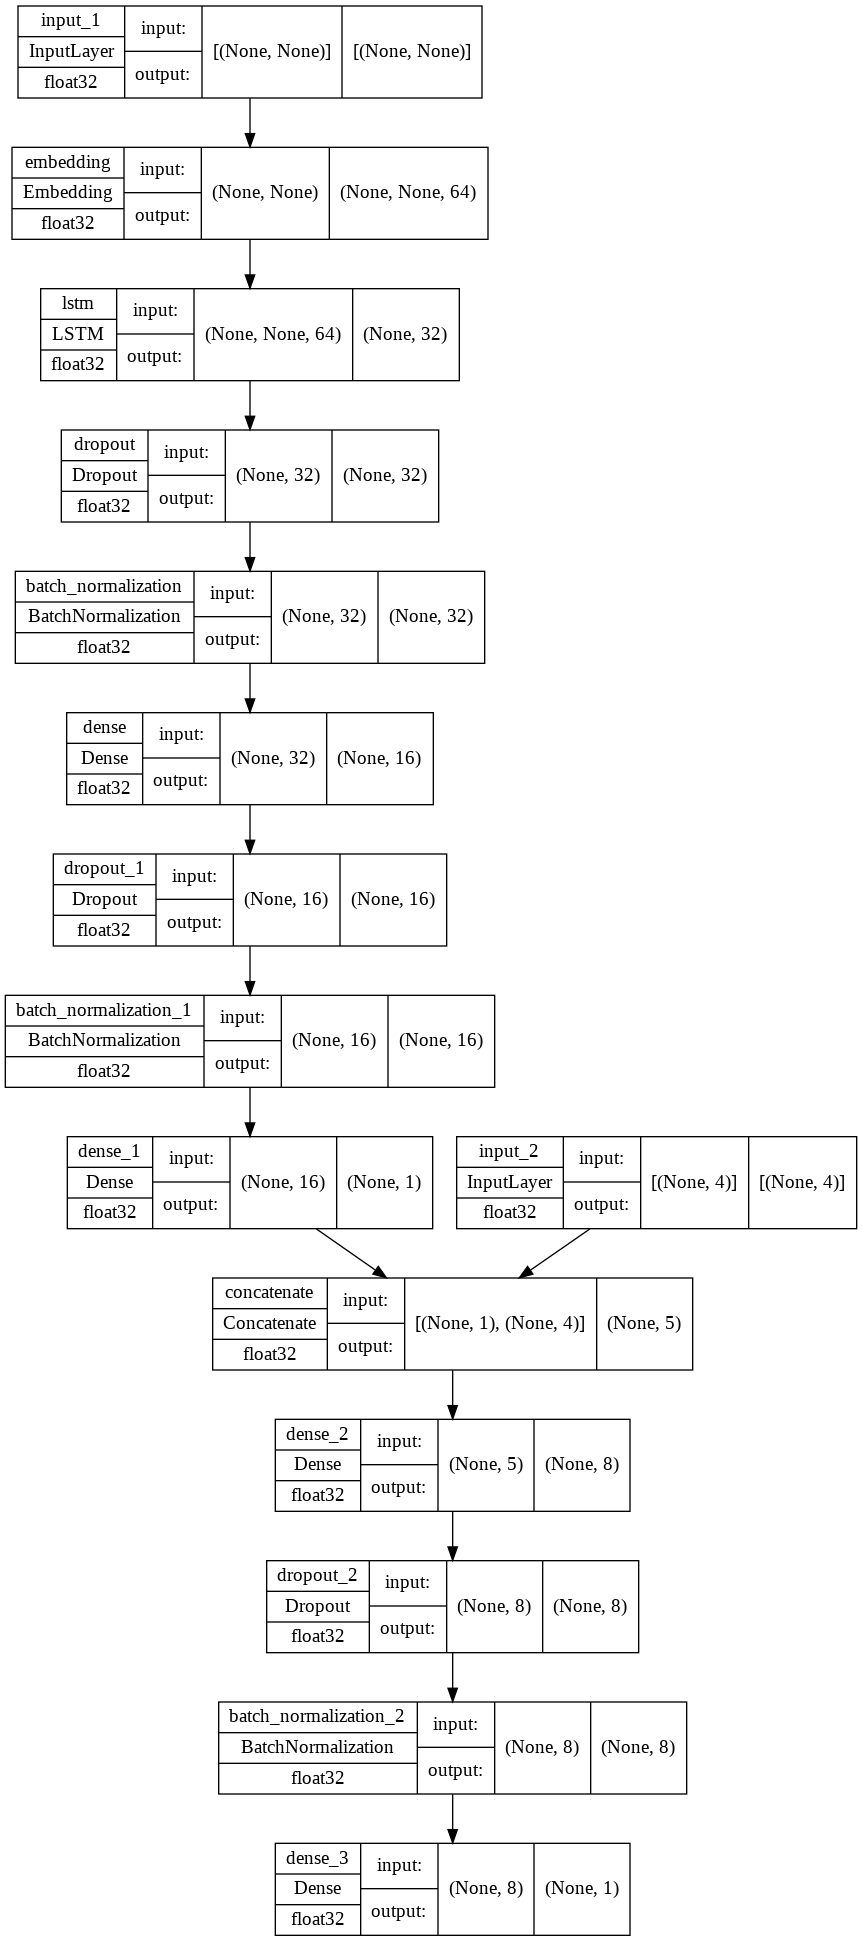

In [ ]:
# building the model

model = build_LSTMmodel()
model.summary()

# plotting the model

tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
%%time 

# Denoting the validation/devlopment data
validation_data = ((np.asarray(list(dev_X['STATUS'])), dev_X[['cEXT', 'cAGR', 'cCON', 'cOPN']]), dev_y )

# training the model
history = model.fit(x = (np.asarray(list(train_X['STATUS'])), train_X[['cEXT', 'cAGR', 'cCON', 'cOPN']]), 
          y = train_y,
          batch_size = 256,
          validation_data = validation_data,
          epochs = 10)

Epoch 1/10
31/31 [==============================] - 145s 4s/step - loss: 0.7437 - accuracy: 0.5367 - val_loss: 0.6466 - val_accuracy: 0.6169
Epoch 2/10
31/31 [==============================] - 138s 4s/step - loss: 0.6847 - accuracy: 0.5821 - val_loss: 0.6304 - val_accuracy: 0.6350
Epoch 3/10
31/31 [==============================] - 150s 5s/step - loss: 0.6554 - accuracy: 0.6173 - val_loss: 0.6251 - val_accuracy: 0.6003
Epoch 4/10
31/31 [==============================] - 137s 4s/step - loss: 0.6322 - accuracy: 0.6416 - val_loss: 0.6224 - val_accuracy: 0.6003
Epoch 5/10
31/31 [==============================] - 137s 4s/step - loss: 0.6248 - accuracy: 0.6447 - val_loss: 0.6211 - val_accuracy: 0.6003
Epoch 6/10
31/31 [==============================] - 139s 4s/step - loss: 0.6057 - accuracy: 0.6623 - val_loss: 0.6191 - val_accuracy: 0.5999
Epoch 7/10
31/31 [==============================] - 137s 4s/step - loss: 0.5896 - accuracy: 0.6735 - val_loss: 0.6166 - val_accuracy: 0.6116
Epoch 8/10
31

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


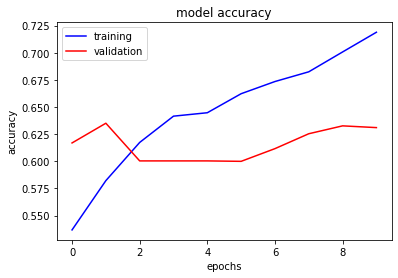

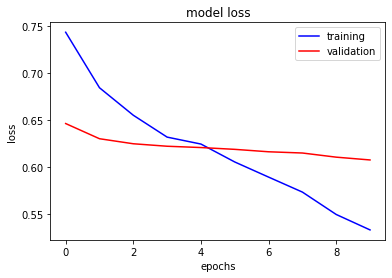

In [ ]:
# plots


print(history.history.keys())

plt.plot(history.history['accuracy'], 'b', label = 'training')
plt.plot(history.history['val_accuracy'], 'r', label = 'validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], 'b', label = 'training')
plt.plot(history.history['val_loss'], 'r',  label = 'validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
# evaluating the model
model.evaluate(x = (np.asarray(list(test_X['STATUS'])), test_X[['cEXT', 'cAGR', 'cCON', 'cOPN']]), 
               y = test_y)

62/62 [==============================] - 19s 294ms/step - loss: 0.6092 - accuracy: 0.6307


[0.6092196702957153, 0.6306760907173157]

In [ ]:
# The names of evauation metrics shown above
model.metrics_names

['loss', 'accuracy']

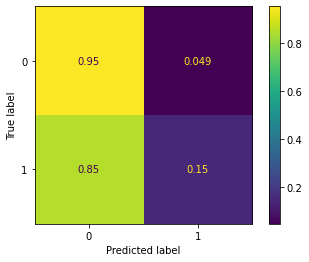

In [ ]:
# plotting the confusion matrix on the test data

predicted_labels = (model.predict((np.asarray(list(test_X['STATUS'])), test_X[['cEXT', 'cAGR', 'cCON', 'cOPN']])) > 0.5) * 1
ConfusionMatrixDisplay.from_predictions(test_y, predicted_labels, normalize = 'true')
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [ ]:
# getting various metrics on test data 

print('Accuracy  = {}'.format(metrics.accuracy_score(predicted_labels,  test_y)))
for label in [0, 1]:
  print('Precision for label {} = {}'.format('no', metrics.precision_score(predicted_labels, test_y, pos_label=label)))
  print('Recall    for label {} = {}'.format('yes', metrics.recall_score(predicted_labels,    test_y, pos_label=label)))

Accuracy  = 0.6306760847628657
Precision for label no = 0.9512605042016806
Recall    for label yes = 0.6267995570321152
Precision for label no = 0.14898989898989898
Recall    for label yes = 0.6704545454545454
